In [1]:
import numpy as np
from scipy.special import expit
from shap.maskers import Independent
from imldiff.models import Model
from imldiff.plots import plot_shap_value_distribution, plot_shap_partial_dependence, plot_shap_values_stacked, \
    plot_shap_values_hierarchically_clustered
import shap
from imldiff.result import merge_functions
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()

# Move Soft Decision Boundary

## Create Models

In [2]:
f1 = lambda X: np.clip(X[:,0] * 50, -5, 5)
f2 = lambda X: np.clip((X[:,0] - 0.15) * 50, -5, 5)

c1 = lambda X: expit(f1(X))
c2 = lambda X: expit(f2(X))

In [3]:
x_from = -1
x_to = 1
feature_names = ['x1']
num_samples = 1000
x1 = np.linspace(x_from, x_to, num_samples)
X = np.reshape(x1, (num_samples, len(feature_names)))

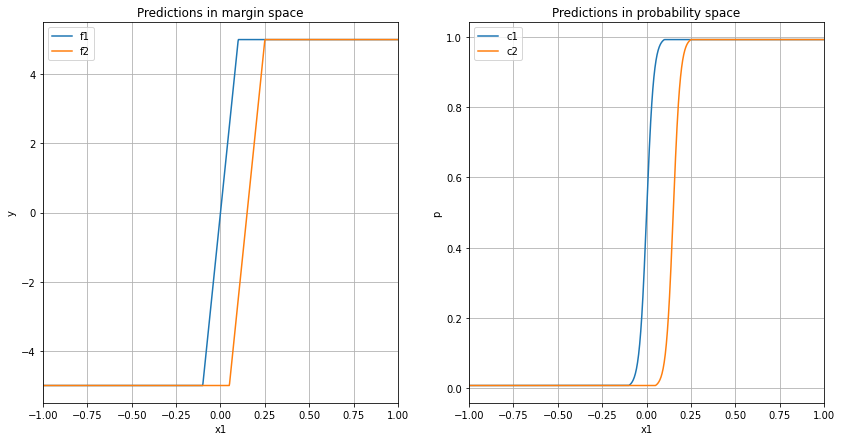

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

ax = axs[0]
ax.plot(x1, f1(X), label='f1')
ax.plot(x1, f2(X), label='f2')
ax.grid()
ax.set_xlim(x_from, x_to)
ax.set_xlabel('x1')
ax.set_ylabel('y')
ax.set_title('Predictions in margin space')
ax.legend()

ax = axs[1]
ax.plot(x1, c1(X), label='c1')
ax.plot(x1, c2(X), label='c2')
ax.grid()
ax.set_xlim(x_from, x_to)
ax.set_xlabel('x1')
ax.set_ylabel('p')
ax.set_title('Predictions in probability space')
ax.legend()
plt.show()

In [20]:
complement = lambda p: 1 - p
c1_positive_and_c2_negative = lambda p1, p2: p1 * complement(p2)
c1_negative_and_c2_positive = lambda p1, p2: complement(p1) * p2
c1_and_c2_different = lambda p1, p2: c1_positive_and_c2_negative(p1, p2) + c1_negative_and_c2_positive(p1, p2)
odds = lambda p: p / complement(p)
log_odds_ratio_from_proba = lambda p1, p2: np.log(odds(p1) / odds(p2))

c_c1_positive_and_c2_negative = lambda X: c1_positive_and_c2_negative(c1(X), c2(X))
c_c1_negative_and_c2_positive = lambda X: c1_negative_and_c2_positive(c1(X), c2(X))
c_c1_and_c2_different = lambda X: c1_and_c2_different(c1(X), c2(X))
f_log_odds_ratio_from_proba = lambda X: log_odds_ratio_from_proba(c1(X), c2(X))

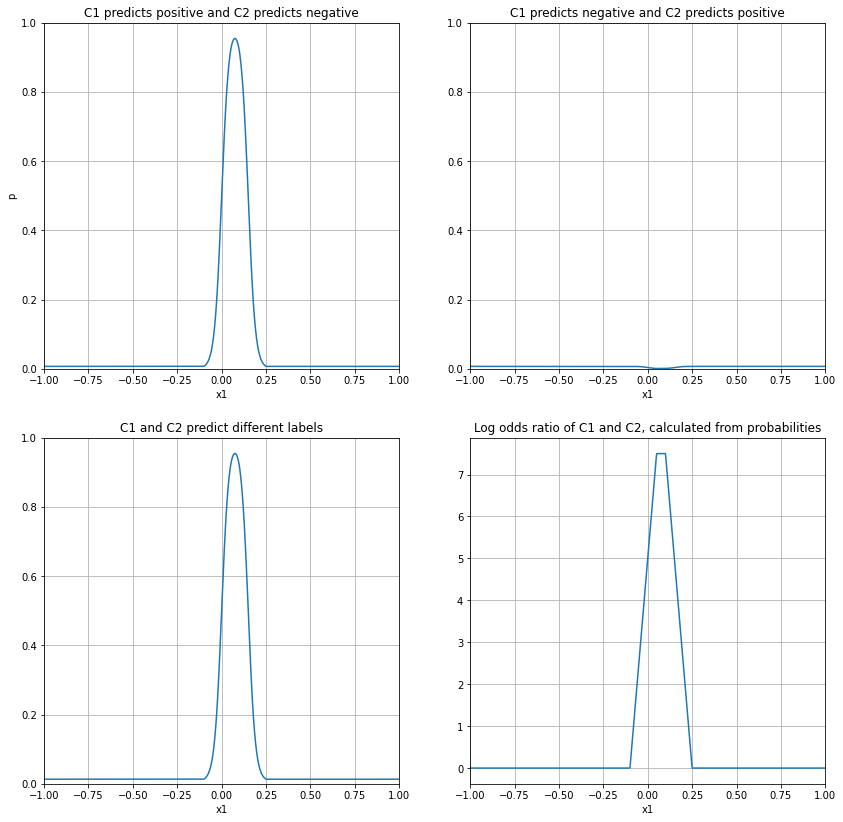

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

ax = axs[0,0]
ax.plot(x1, c_c1_positive_and_c2_negative(X))
ax.grid()
ax.set_xlim(x_from, x_to)
ax.set_ylim(0, 1)
ax.set_xlabel('x1')
ax.set_ylabel('p')
ax.set_title('C1 predicts positive and C2 predicts negative')

ax = axs[0,1]
ax.plot(x1, c_c1_negative_and_c2_positive(X), label='Probability: ')
ax.grid()
ax.set_xlim(x_from, x_to)
ax.set_ylim(0, 1)
ax.set_xlabel('x1')
ax.set_title('C1 predicts negative and C2 predicts positive')

ax = axs[1,0]
ax.plot(x1, c_c1_and_c2_different(X))
ax.grid()
ax.set_xlim(x_from, x_to)
ax.set_ylim(0, 1)
ax.set_xlabel('x1')
ax.set_title('C1 and C2 predict different labels')

ax = axs[1,1]
ax.plot(x1, f_log_odds_ratio_from_proba(X))
ax.grid()
ax.set_xlim(x_from, x_to)
ax.set_xlabel('x1')
ax.set_title('Log odds ratio of C1 and C2, calculated from probabilities')
plt.show()

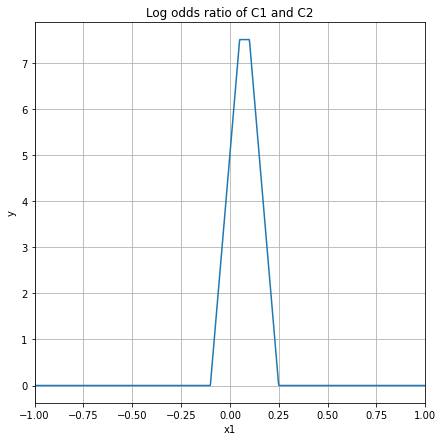

In [25]:
log_odds_ratio = lambda y1, y2: y1 - y2
f_log_odds_ratio = lambda X: log_odds_ratio(f1(X), f2(X))

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(x1, f_log_odds_ratio(X))
ax.grid()
ax.set_xlim(x_from, x_to)
ax.set_xlabel('x1')
ax.set_ylabel('y')
ax.set_title('Log odds ratio of C1 and C2')
plt.show()

## Generate Explanations

In [6]:
background_data = X

class SHAPExplainer(Model):
    def __init__(self, model):
        self.model = model
    @property
    def _prediction_str(self):
        return f'S({self.model})'
    def __call__(self, X):
        masker = Independent(background_data)
        explainer = shap.Explainer(self.model, masker, feature_names=feature_names)
        shap_values = explainer(X)
        shap_values.display_data = X
        return shap_values


single_model_explanations = [SHAPExplainer(classifier).predict(X) for classifier in classifiers]
#merged_explanations = [func(*single_model_explanations) for func in merge_functions]
#for explanation in merged_explanations:
#    explanation.values.data = X
merged_models_explanations = [SHAPExplainer(classifier).predict(X) for classifier in merged_classifiers]

explanations = single_model_explanations + merged_models_explanations

## Analyze

### SHAP Value Distribution

In [7]:
merged_explanations = [func(*single_model_explanations) for func in merge_functions]
for explanation in merged_explanations:
   explanation.values.data = X

In [8]:
from imldiff.result import Result
shap_values = single_model_explanations[0].values * (1-single_model_explanations[1].values)
test_explanation = Result('Test', shap_values)
test_explanation.values.data = X
test_explanation.values.display_data = X

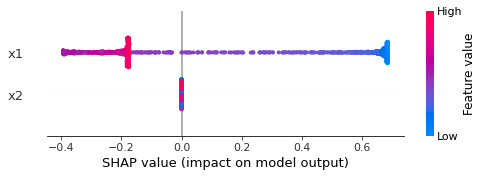

In [9]:
shap.plots.beeswarm(shap_values)

In [13]:
for explanation in explanations + merged_explanations + [test_explanation]:
    print(f'{explanation}: {explanation.values.values.min()}, {explanation.values.values.mean()}, {explanation.values.values.max()}')

S(C): -0.5068746357027003, 0.010254212094986786, 0.47291223037364105
S(D): -0.3510705968695406, 0.013377198122521411, 0.6287155088962915
S(Both different): -0.168688341872892, -0.00338124312195229, 0.5050154486048969
S(A positive and b negative): -0.1622461903530258, -0.0032521145747434438, 0.4857290770414294
S(A negative and b positive): -0.006442151519866205, -0.0001291285472088874, 0.019286371563468303
((S(C) * S(D)') + (S(C)' * S(D))): -0.5069732321046446, 0.14016577346739822, 1.213842794360597
(S(C) * S(D)'): -0.3935527817891082, 0.07164437974746643, 0.6848234165968783
(S(C)' * S(D)): -0.3313882553136475, 0.06852139371993178, 0.5290193777637185
Test: -0.3935527817891082, 0.07164437974746643, 0.6848234165968783


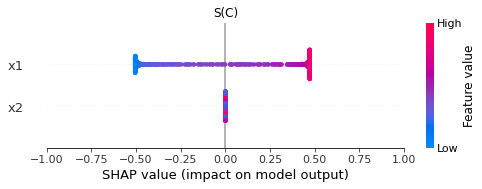

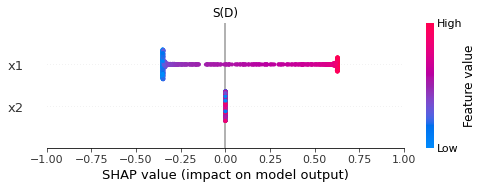

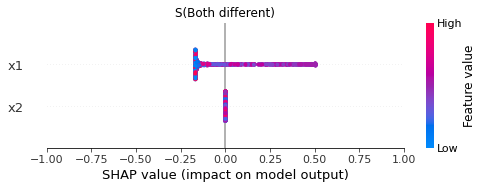

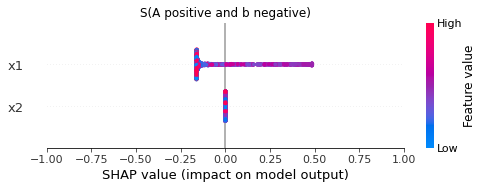

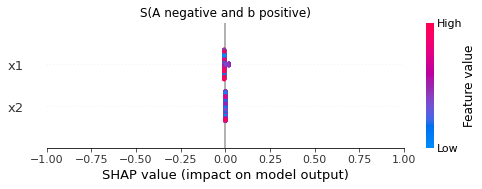

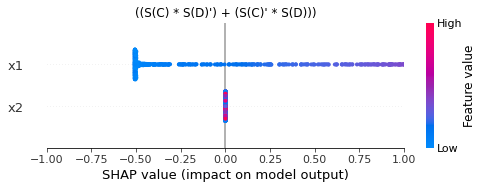

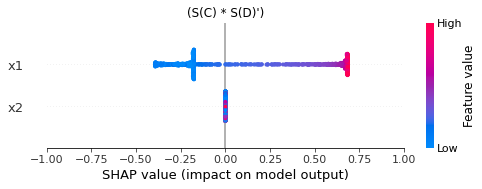

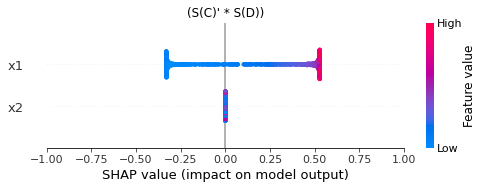

In [12]:
for explanation in explanations + merged_explanations:
    plot_shap_value_distribution(explanation)

### Features' Partial Dependence Plots

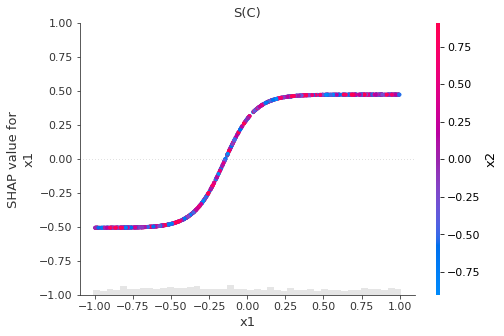

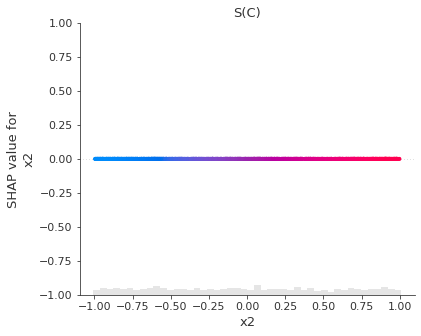

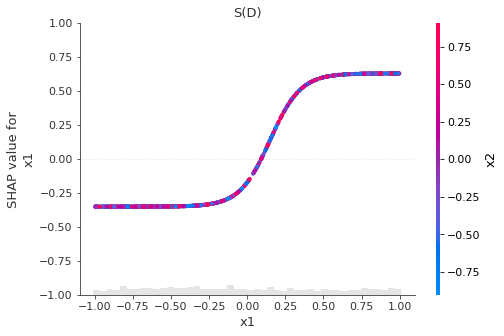

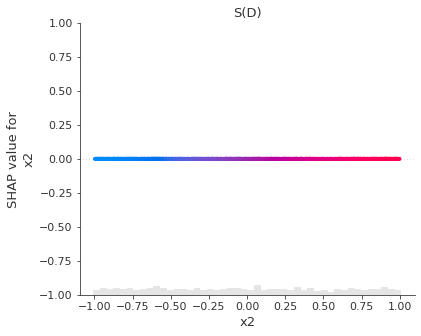

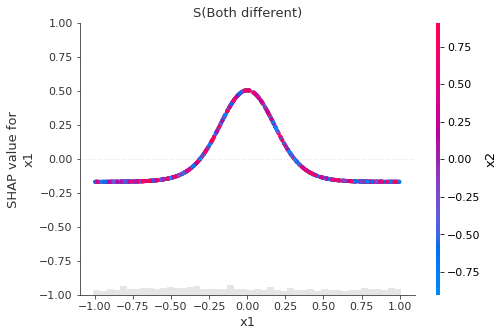

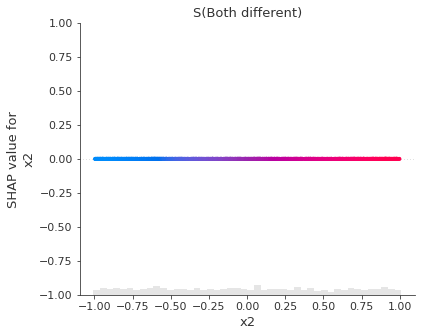

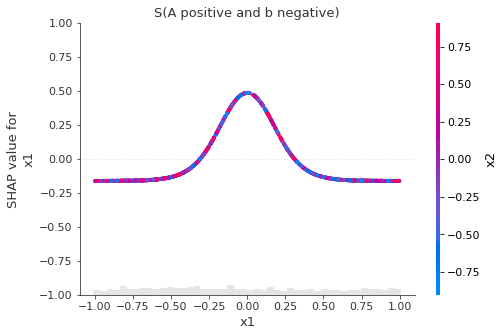

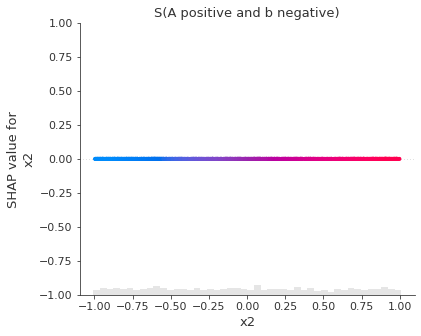

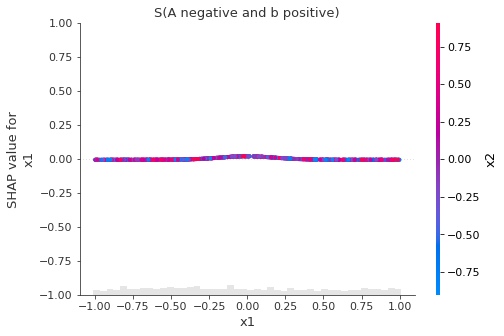

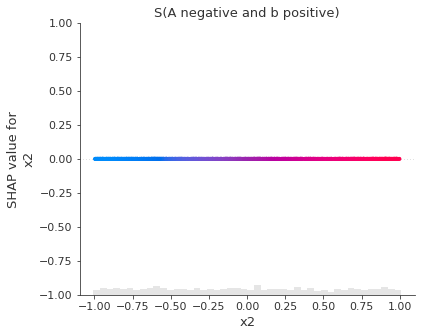

In [8]:
for explanation in explanations:
    plot_shap_partial_dependence(explanation)

### Stacked SHAP Explanations, Clustered by Similarity

In [9]:
plot_shap_values_stacked(*single_model_explanations)

for explanation in merged_explanations:
    plot_shap_values_stacked(explanation)

### Hierarchically Clustered SHAP Values

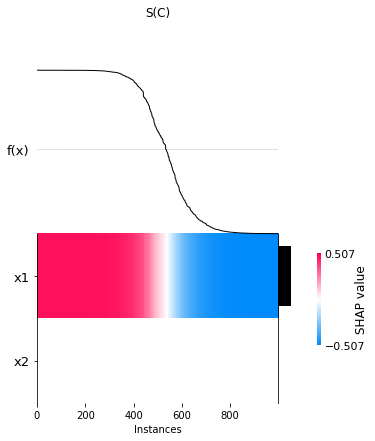

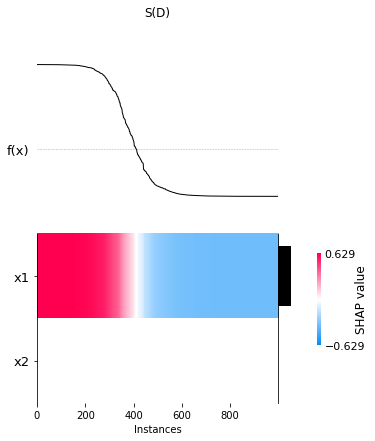

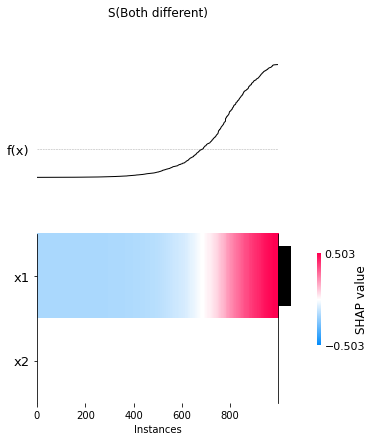

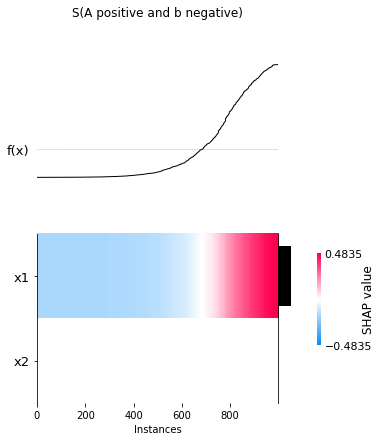

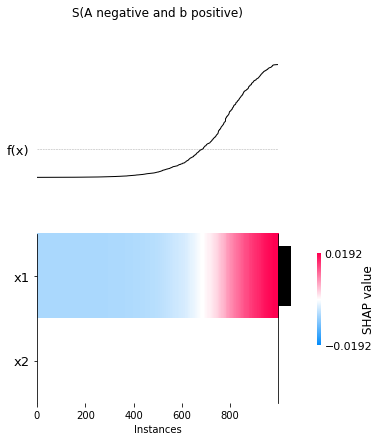

In [10]:
for explanation in explanations:
    plot_shap_values_hierarchically_clustered(explanation)